In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from E_model import model, show_plot

In [2]:
num_samples = 100
sigma_big = 0.2
sigma_small = 0.01
p = [0.4597, 1.1255, 0.6814, 0.0094, 0.1913]

Yxs_dist = np.random.normal(p[0], sigma_big, num_samples)
qs_max_dist = np.random.normal(p[1], sigma_big, num_samples)
Ks_dist = np.random.normal(p[2], sigma_big, num_samples)
m_s_dist = np.random.normal(p[3], sigma_small, num_samples)
lag_dist = np.random.normal(p[4], sigma_small, num_samples)

df_p = pd.DataFrame({
    'Yxs': Yxs_dist,
    'qs_max': qs_max_dist,
    'Ks': Ks_dist,
    'm_s': m_s_dist,
    'lag': lag_dist
})
df_p.describe()

,Yxs,qs_max,Ks,m_s,lag
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.459771,1.087389,0.700638,0.007444,0.192252
std,0.222286,0.202286,0.219156,0.009250,0.009699
min,-0.033577,0.611873,0.146039,-0.014364,0.166583
25%,0.303695,0.962148,0.555579,0.001421,0.186909
50%,0.468520,1.070006,0.706662,0.007566,0.192060
75%,0.574046,1.203249,0.855147,0.012666,0.198428
max,1.204343,1.582636,1.175520,0.031542,0.226018


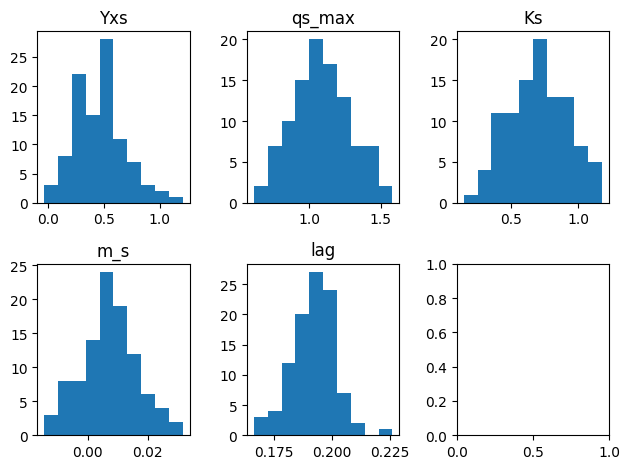

In [3]:
# check if there are enough samples to have a normal distribution
fig, ax = plt.subplots(2, 3)
ax[0,0].hist(df_p['Yxs'])
ax[0,0].set_title('Yxs')
ax[0,1].hist(df_p['qs_max'])
ax[0,1].set_title('qs_max')
ax[0,2].hist(df_p['Ks'])
ax[0,2].set_title('Ks')
ax[1,0].hist(df_p['m_s'])
ax[1,0].set_title('m_s')
ax[1,1].hist(df_p['lag'])
ax[1,1].set_title('lag')
plt.tight_layout()

In [ ]:
# define sample frequency
# --> higher frequency reduces the amount of data that has to be stored
delta_t = 2 #[min]

df_batches = pd.DataFrame(columns=['time', 'biomass', 'glucose', 'batch_id'])
for i in range(df_p.shape[0]):
    batch_id = str(i).zfill(3)
    list_p = list(df_p.iloc[i])
    df = model(list_p, delta_t)
    df['batch_id'] = str(batch_id)
    # show_plot(df)
    df_batches = pd.concat([df_batches, df], ignore_index=True)

df_batches.to_csv('data/generated data/df_gen.csv')

In [ ]:
df_gen = pd.read_csv('data/generated data/df_gen_0407.csv')
df_gen['batch_id'] = df_gen['batch_id'].astype(str).str.zfill(3)

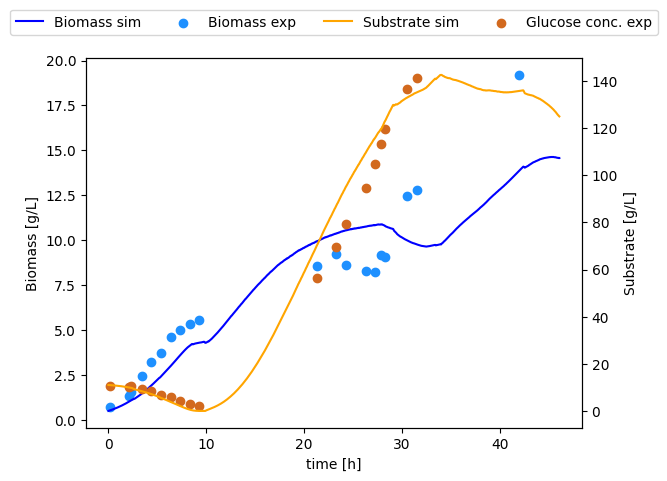

In [ ]:
df_one = df_gen[df_gen['batch_id'] == '436']
show_plot(df_one)